# Foyer Tutorial 02: SMARTS for Non-Atomistic Systems

This tutorial focuses on how to perform atom-typing for systems that are not fully atomistic (i.e., united-atom models and coarse-grained models). 

Thus far, all of our tutorials for mBuild and Foyer have focused on fully atomistic systems, however, MoSDeF is not limited to such systems. 

First, we will demonstrate how to construct a generic coarse-grained polymer system using mBuild, then demonstrate how to define an associated forcefield file.

In [1]:
%matplotlib notebook
from visualize import visualize
import mbuild as mb

As done previous in the mBuild tutorials, we will create `Compounds` to describe repeat units in our polymer. Here we will create two `Compounds`, one to describe the central beads (`_A`) and one for the terminal groups (`_B`).

Note, to properly handle non-atomistic types, Foyer expects names to be prefaced by an underscore (e.g., `_A`,`_B`, `_CH2`, etc. ).

<IPython.core.display.Javascript object>


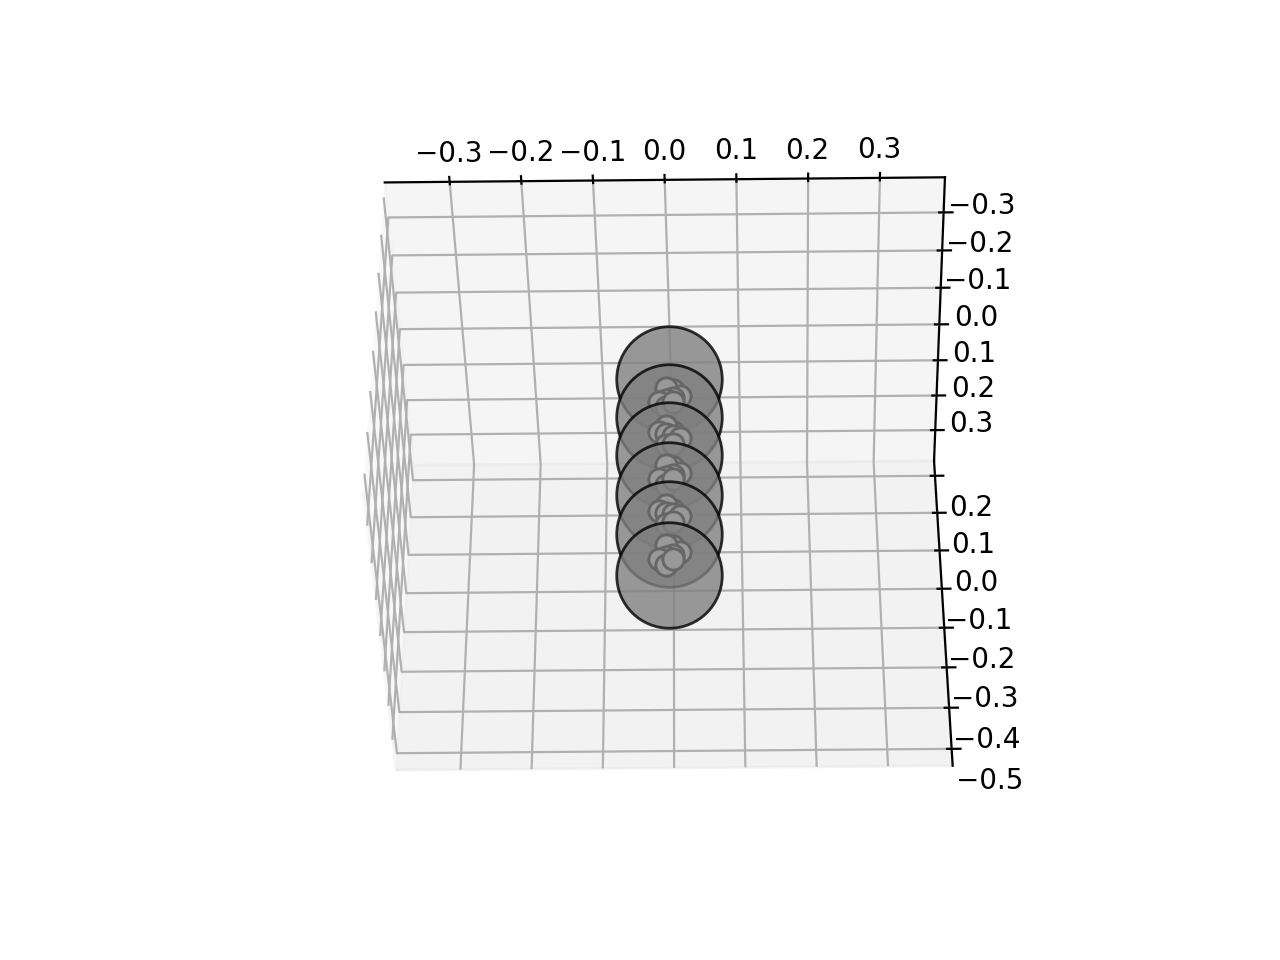

In [20]:
class CentralBead(mb.Compound):
    def __init__(self):
        super(CentralBead, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_A')
        self.add(bead)
        up_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.05)
        down_port = mb.Port(anchor=bead, orientation=[0, 0, -1], separation=0.05)
        self.add(up_port, label='up')
        self.add(down_port, label='down')
        
class TerminalBead(mb.Compound):
    def __init__(self):
        super(TerminalBead, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_B')
        self.add(bead)

        cap_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.05)
        self.add(cap_port, label='cap')

class CGPolymer(mb.Compound):
    def __init__(self, chain_length):
        super(CGPolymer, self).__init__()
        
        terminal_bead = TerminalBead()
        last_unit = CentralBead()
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['up'])
        self.add(last_unit, label='_A[$]')
        self.add(terminal_bead, label='up-cap')   
        for _ in range(chain_length - 3):
            current_unit = CentralBead()
            mb.force_overlap(move_this=current_unit,
                             from_positions=current_unit['up'],
                             to_positions=last_unit['down'])
            self.add(current_unit, label='_A[$]')
            last_unit=current_unit
        terminal_bead = TerminalBead()
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['down'])
        self.add(terminal_bead, label='down-cap')
        if chain_length < 3:
            print("Note, the shortest chain this function will make is 3")
cg_polymer = CGPolymer(chain_length=6)
visualize(cg_polymer)

With a simple mBuild code to create CG polymers, let us examine how to define a forcefield file.

In this forcefield, we will assume all particles have the same bonds, angles, and Lennard-Jones sigma, regardless of type, however, we will modify Lennard-Jones epsilon based on chemical context. 

Here we will define the forcefield such that:
- when bead `_A` has 2 bonded neighbors of type `_A`, epsilon = 1.0 
 - atom-type: `cg_A_AA`
 - SMARTS definition: `[_A;X2](_A)(_A)`
- when bead `_A` has 1 bonded neighbor of type `_A` and one of type `_B`, epsilon = 1.25 
 - atom-type `cg_A_AB`
 - SMARTS definition: `[_A;X2](_A)(_B)`
- when bead `_A` has 2 bonded neighbors of type `_B`  epsilon = 1.5
 - atom-type `cg_A_BB`
 - SMARTS definition: `[_A;X2](_B)(_B)`
- when bead `_B` has any neighbor, epsilon = 2.0 regardless of who it is bonded 
 - `atom-type cg_B`
 - SMARTS definition: `[_B;X1]`

The xml forcefield file is shown below:

In [24]:
cat CG_polymer.xml

<ForceField>
    <AtomTypes>
        <Type name="cg_A_AA" def="[_A;X2](_A)(_A)"
              class="CT" element="_A" mass="1.0"
              desc="generic CG central bead, with two _A neighbors"/>
        <Type name="cg_A_AB" def="[_A;X2](_A)(_B)"
              class="CT" element="_A" mass="1.0"
              desc="generic CG central bead with dissimilar neighbors"/>
        <Type name="cg_A_BB" def="[_A;X2](_B)(_B)"
              class="CT" element="_A" mass="1.0"
              desc="generic CG central bead with two _B neighbors"/>
        <Type name="cg_B" def="[_B;X1]"
              class="CT" element="_B" mass="1.0"
              desc="generic CG terminal bead"/>
    </AtomTypes>
    <HarmonicBondForce>
        <Bond class1="CT" class2="CT" length="0.1" k="20000"/>
    </HarmonicBondForce>
    <HarmonicAngleForce>
        <Angle class1="CT" class2="CT" class3="CT" angle="3.0" k="500"/>
    </HarmonicAngleForce>
    <RBTorsionForce>
    </RBTorsionForce>
    <NonbondedForce coulom

cg_polymer.save('CGpolymer.top', forcefield_files='CG_polymer.xml', overwrite=True)

We can then easily view the outputted file to check for correctness

In [34]:
cat CGpolymer.top

;
;   File CGpolymer.top  was generated
;   By user: cri (503)
;   On host: IacBook-Pro-Retina.local
;   At date: Thu. November  4 11:41:04 2017
;
;   This is a standalone topology file
;
;   Created by:
;   ParmEd:       __main__.py, VERSION 2.7.3
;   Executable:   __main__.py
;   Library dir:  /usr/local/gromacs/share/gromacs/top
;   Command line:
;     /Users/cri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py -f /Users/cri/Library/Jupyter/runtime/kernel-cfab7bb1-a43f-41e0-93e7-27392f7682d5.json
;

[ defaults ]
; nbfunc        comb-rule       gen-pairs       fudgeLJ fudgeQQ
1               2               no              1             1

[ atomtypes ]
; name    at.num    mass    charge ptype  sigma      epsilon
cg_A_AB        0    1.00000    0.000000  A           0.1          1.25
cg_B           0    1.00000    0.000000  A           0.1             2
cg_A_AA        0    1.00000    0.000000  A           0.1             1


[ moleculetype ]
; Name            nrexcl
RES    

The above example does not include atom-type `cg_A_BB`; to test that our definition is correct, we will create a shorter polymer of length 3 that will include this type.

In [35]:
cg_polymer3 = CGPolymer(chain_length=3)
cg_polymer3.save('CGpolymer3.top', forcefield_files='CG_polymer.xml', overwrite=True)

/Users/cri/Projects/mbuild/mbuild/compound.py:1740: UserWarning: Guessing that "<_A pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4675487728>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/cri/Projects/mbuild/mbuild/compound.py:1740: UserWarning: Guessing that "<_B pos=(-0.0000,-0.0000, 0.1000), 0 bonds, id: 4662963392>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/cri/Projects/foyer/foyer/foyer/forcefield.py:187: UserWarning: Non-atomistic element type detected. Creating custom element for _A
  'Creating custom element for {}'.format(element))
/Users/cri/Projects/foyer/foyer/foyer/forcefield.py:187: UserWarning: Non-atomistic element type detected. Creating custom element for _B
  'Creating custom element for {}'.format(element))
/Users/cri/Projects/plyplus/plyplus/plyplus.py:758: DeprecationWarning: invalid escape sequence '\#'
  return codecs.getdecoder('unicode_escape')(token_value)[0]
/Users

In [36]:
cat CGpolymer3.top

;
;   File CGpolymer3.top  was generated
;   By user: cri (503)
;   On host: IacBook-Pro-Retina.local
;   At date: Thu. November  4 11:44:22 2017
;
;   This is a standalone topology file
;
;   Created by:
;   ParmEd:       __main__.py, VERSION 2.7.3
;   Executable:   __main__.py
;   Library dir:  /usr/local/gromacs/share/gromacs/top
;   Command line:
;     /Users/cri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py -f /Users/cri/Library/Jupyter/runtime/kernel-cfab7bb1-a43f-41e0-93e7-27392f7682d5.json
;

[ defaults ]
; nbfunc        comb-rule       gen-pairs       fudgeLJ fudgeQQ
1               2               yes             1             1

[ atomtypes ]
; name    at.num    mass    charge ptype  sigma      epsilon
cg_A_BB        0    1.00000    0.000000  A           0.1           1.5
cg_B           0    1.00000    0.000000  A           0.1             2


[ moleculetype ]
; Name            nrexcl
RES          3

[ atoms ]
;   nr       type  resnr residue  atom   cgnr    ch

The same approach can be taken for united atom forcefields, such as TraPPE. The following line could be used to describe beads representing _CH2 groups in a polymer. 

`  <Type name="CH2_sp3" class="CH2" element="_CH2" mass="14.02700" 
   def="[_CH2;X2]([_CH3,_CH2])[_CH3,_CH2]" 
   desc="Alkane CH2, united atom" doi="10.1021/jp972543+"/>`
  
Here, the SMARTS definition `[_CH2;X2]([_CH3,_CH2])[_CH3,_CH2]` states that for atom-type `CH2_sp3`
-  our bead is _CH2 with 2 bonded neighbors, i.e., `[_CH2;X2]`
- those neighbors can be either _CH2 or _CH3, i.e., `([_CH3,_CH2])[_CH3,_CH2]`
